In [1]:
import uproot
import awkward as ak
from coffea import nanoevents
from coffea.nanoevents.methods.base import NanoEventsArray
from coffea.analysis_tools import Weights, PackedSelection
from coffea.nanoevents.methods import nanoaod
from coffea.nanoevents.methods import vector
from coffea.lookup_tools.dense_lookup import dense_lookup

ak.behavior.update(vector.behavior)

import pickle, json, gzip
import numpy as np

from typing import Optional, List, Dict
from copy import copy

import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib import colors

from tqdm import tqdm
import fastjet

# import jetnet

import os

import corrections
import correctionlib


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plot_dir = "../../../plots/ScaleFactors/Nov23"
_ = os.system(f"mkdir -p {plot_dir}")


In [3]:
events = nanoevents.NanoEventsFactory.from_root(
    # "/eos/uscms/store/user/lpcpfnano/cmantill/v2_3/2017/HH_gen/GluGluToHHTobbVV_node_cHHH1_TuneCP5_13TeV-powheg-pythia8/GluGluToHHTobbVV_node_cHHH1/221017_221918/0000/nano_mc2017_100.root",
    # "/eos/uscms/store/user/lpcpfnano/drankin/v2_2/2017/TTbar/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic_ext1/211112_132937/0000/nano_mc2017_100.root",
    # "../../../../data/nano_files/v2_3/2018/TTToSemiLeptonic/nano_mc2018_101.root",
    "root://cmsxrootd.fnal.gov///store/user/lpcpfnano/cmantill/v2_3/2018/TTbar/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic/220808_151244/0000/nano_mc2018_1-196.root",
    schemaclass=nanoevents.NanoAODSchema,
).events()


/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (1937 branches) at 0x7f12f84ddb80>, taking first instance
  warnings.warn(
/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (1937 branches) at 0x7f12f84ddb80>, taking first instance
  warnings.warn(
/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (1937 branches) at 0x7f12f84ddb80>, taking first instance
  warnings.warn(
/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15_nCHadrons in <TTree 'Eve

### Boosted Top Pre-selection

Based on selection in https://indico.cern.ch/event/1208247/#10-lund-plane-reweighting-for

In [4]:
def pad_val(
    arr: ak.Array,
    target: int,
    value: float,
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    return ret.to_numpy() if to_numpy else ret


def add_selection(
    name: str,
    sel: np.ndarray,
    selection: PackedSelection,
    cutflow: dict = None,
    isData: bool = False,
    signGenWeights: ak.Array = None,
):
    """adds selection to PackedSelection object and the cutflow dictionary"""
    selection.add(name, sel)
    if cutflow is not None:
        cutflow[name] = (
            np.sum(selection.all(*selection.names))
            if isData
            # add up sign of genWeights for MC
            else np.sum(signGenWeights[selection.all(*selection.names)])
        )


presel_events = events
# presel_events = events[preselection_cut]


In [5]:
isData = False
signGenWeights = None if isData else np.sign(presel_events["genWeight"])
n_events = len(presel_events) if isData else int(np.sum(signGenWeights))
selection = PackedSelection()

cutflow = {}
cutflow["presel"] = len(presel_events)


In [6]:
MU_PDGID = 13

muon_selection = {
    "Id": "tight",
    "pt": 60,
    "eta": 2.4,
    "miniPFRelIso_all": 0.1,
    "dxy": 0.2,
    "count": 1,
    "delta_trigObj": 0.15,
}

ak8_jet_selection = {
    "pt": 200,
    "msd": [50, 250],
    "eta": 2.5,
    "delta_phi_muon": 2,
    "jetId": nanoaod.FatJet.TIGHT,
}

btagWPs = {"2016APV": 0.6001, "2016": 0.5847, "2017": 0.4506, "2018": 0.4168}

ak4_jet_selection = {
    "pt": 25,
    "eta": 2.4,
    "delta_phi_muon": 2,
    "jetId": nanoaod.Jet.TIGHT,
    "puId": 4,  # loose pileup ID
    "btagWP": btagWPs,
}

met_selection = {"pt": 50}

lepW_selection = {"pt": 100}


In [7]:
muon = events.Muon
# 1024 - Mu50 trigger (https://algomez.web.cern.ch/algomez/testWeb/PFnano_content_v02.html#TrigObj)
trigObj_muon = events.TrigObj[(events.TrigObj.id == MU_PDGID) * (events.TrigObj.filterBits >= 1024)]

muon_selector = (
    (muon[f"{muon_selection['Id']}Id"])
    * (muon.pt > muon_selection["pt"])
    * (np.abs(muon.eta) < muon_selection["eta"])
    * (muon.miniPFRelIso_all < muon_selection["miniPFRelIso_all"])
    * (np.abs(muon.dxy) < muon_selection["dxy"])
)

muon_selector = muon_selector * (
    ak.count(events.Muon.pt[muon_selector], axis=1) == muon_selection["count"]
)
muon = ak.pad_none(muon[muon_selector], 1, axis=1)[:, 0]

muon_selector = ak.any(muon_selector, axis=1)
muon_selector = muon_selector * ak.any(
    np.abs(muon.delta_r(trigObj_muon)) <= muon_selection["delta_trigObj"],
    axis=1,
)


In [8]:
# met
met = events.MET
met_selection = met.pt >= met_selection["pt"]

# metfilters = np.ones(len(events), dtype="bool")
# metfilterkey = "data" if isData else "mc"
# for mf in self.metfilters[year][metfilterkey]:
#     if mf in events.Flag.fields:
#         metfilters = metfilters & events.Flag[mf]

add_selection("met", met_selection * metfilters, *selection_args)

# leptonic W selection
# add_selection("lepW", (met + muon).pt >= self.lepW_selection["pt"], *selection_args)
add_selection("lepW", met.pt + muon.pt >= 100, *selection_args)


NameError: name 'self' is not defined

In [12]:
# fatjets = events.FatJet  # CHANGE TO JEC JETS
fatjets = corrections.get_jec_jets(events, "2018")
num_jets = 1

fatjet_selector = (
    (fatjets.pt > ak8_jet_selection["pt"])
    # * (fatjets.msoftdrop > ak8_jet_selection["msd"][0])
    # * (fatjets.msoftdrop < ak8_jet_selection["msd"][1])
    * (np.abs(fatjets.eta) < ak8_jet_selection["eta"])
    # * (np.abs(fatjets.delta_phi(muon)) > ak8_jet_selection["delta_phi_muon"])
    * (fatjets.jetId > ak8_jet_selection["jetId"])
)

leading_fatjets = ak.pad_none(fatjets[fatjet_selector], num_jets, axis=1)[:, :num_jets]
fatjet_idx = ak.argmax(fatjet_selector, axis=1)  # gets first index which is true
fatjet_selector = ak.any(fatjet_selector, axis=1)


In [ ]:
hem_region = {"eta": [-3.2, -1.3], "phi": [-0.87, -1.57]}
hem_region_selector = (
    (fatjets.eta > hem_region["eta"][0])
    * (fatjets.eta < hem_region["eta"][1])
    * (fatjets.phi > hem_region["phi"][0])
    * (fatjets.phi < hem_region["phi"][1])
)


In [13]:
ak4_jets = events.Jet
# ak4_jets = ak.flatten(
#     ak.pad_none(events.Jet[ak.argsort(events.Jet.btagDeepB, axis=1)[:, -1:]], 1, axis=1)
# )

ak4_jet_selector = (
    (ak4_jets.jetId > ak4_jet_selection["jetId"])
    * (ak4_jets.puId >= ak4_jet_selection["puId"])
    * (ak4_jets.pt > ak4_jet_selection["pt"])
    * (np.abs(ak4_jets.eta) < ak4_jet_selection["eta"])
    * (np.abs(ak4_jets.delta_phi(muon)) < ak4_jet_selection["delta_phi_muon"])
    * (ak4_jets.btagDeepB > ak4_jet_selection["btagWP"]["2018"])
)

ak4_jet_selector = ak.any(ak4_jet_selector, axis=1)


In [14]:
select = ak.fill_none(muon_selector * fatjet_selector * ak4_jet_selector, False)
presel_events = events[select]
leading_fatjets = leading_fatjets[select]
fatjet_idx = fatjet_idx[select]


In [ ]:
import json, gzip

with gzip.open(corrections.get_pog_json("jec", "2017"), "r") as fin:
    jec = json.loads(fin.read().decode("utf-8"))

for corr in jec["corrections"]:
    print(corr["name"])


In [14]:
with gzip.open("../data/jec_compiled.pkl.gz", "rb") as filehandler:
    jmestuff = pickle.load(filehandler)

jmestuff["jet_factory"]


/tmp/ipykernel_18332/2321762064.py:2: DeprecationWarning: Please use `interp1d` from the `scipy.interpolate` namespace, the `scipy.interpolate.interpolate` namespace is deprecated.
  jmestuff = pickle.load(filehandler)


{'2016mc': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7f72bafb77f0>,
 '2016mcNOJER': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7f72e0a20af0>,
 '2017mc': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7f72e0a46820>,
 '2017mcNOJER': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7f72caf46ca0>,
 '2018mc': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7f72cad52580>,
 '2018mcNOJER': <coffea.jetmet_tools.CorrectedJetsFactory.CorrectedJetsFactory at 0x7f72ca03ea00>}

### Top matching

In [15]:
d_PDGID = 1
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

b_PDGIDS = [511, 521, 523]

GRAV_PDGID = 39

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999


skim_vars = {
    "eta": "eta",
    "phi": "phi",
    "mass": "mass",
    "pt": "pt",
}

# finding the two gen tops
presel_events = events[select]
tops = presel_events.GenPart[
    (abs(presel_events.GenPart.pdgId) == TOP_PDGID) * presel_events.GenPart.hasFlags(GEN_FLAGS)
]


In [16]:
deltaR = 0.8


In [17]:
tops_children = tops.distinctChildren
tops_children = tops_children[tops_children.hasFlags(GEN_FLAGS)]
ws = ak.flatten(tops_children[np.abs(tops_children.pdgId) == W_PDGID], axis=2)
had_top_sel = np.all(np.abs(ws.children.pdgId) <= 5, axis=2)
had_ws = ak.flatten(ws[had_top_sel])
had_tops = ak.flatten(tops[had_top_sel])
had_top_children = ak.flatten(tops_children[had_top_sel], axis=1)
had_bs = had_top_children[np.abs(had_top_children.pdgId) == 5]
# add_selection(
#     "hadronic bs", np.any(had_bs.pdgId, axis=1), selection, cutflow, isData, signGenWeights
# )


In [18]:
had_w_jet_match = ak.fill_none(
    ak.all(had_ws.children.delta_r(leading_fatjets[:, 0]) < deltaR, axis=1), False
)
had_b_jet_match = ak.flatten(
    pad_val(had_bs.delta_r(leading_fatjets[:, 0]) < deltaR, 1, False, axis=1, to_numpy=False)
)
merged_top_jet_match = had_w_jet_match * had_b_jet_match


In [23]:
had_bs


<GenParticleArray [[GenParticle], ... [GenParticle]] type='699 * option[var * ?g...'>

In [26]:
had_ws_children = had_ws.children


In [19]:
top_match_dict = {
    "top_matched": had_w_jet_match * had_b_jet_match,
    "w_matched": had_w_jet_match * ~had_b_jet_match,
    "unmatched": ~had_w_jet_match,
}


### Clustering and Lund plane splittings

In [20]:
merged_top_events = presel_events[merged_top_jet_match]
had_top_jets = merged_top_events.FatJet[:, 0]

merged_ak8_pfcands = merged_top_events.FatJetPFCands
merged_ak8_pfcands = merged_ak8_pfcands[
    merged_ak8_pfcands.jetIdx == fatjet_idx[merged_top_jet_match]
]
merged_pfcands = merged_top_events.PFCands[merged_ak8_pfcands.pFCandsIdx]


In [21]:
merged_pfcands_vector_ptetaphi = ak.Array(
    [
        [{kin_key: cand[kin_key] for kin_key in skim_vars} for cand in event_cands]
        for event_cands in merged_pfcands
    ],
    with_name="PtEtaPhiMLorentzVector",
)


In [22]:
# jet definitions
dR = 0.8
cadef = fastjet.JetDefinition(fastjet.cambridge_algorithm, dR)
ktdef = fastjet.JetDefinition(fastjet.kt_algorithm, dR)

num_prongs = 3


In [27]:
# cluster first with kT
kt_clustering = fastjet.ClusterSequence(merged_pfcands_vector_ptetaphi, ktdef)
kt_subjets = kt_clustering.exclusive_jets(num_prongs)
kt_subjets_pt = np.sqrt(kt_subjets.px**2 + kt_subjets.py**2)
kt_subjet_consts = kt_clustering.exclusive_jets_constituents(3)

# then re-cluster with CA
# won't need to flatten once https://github.com/scikit-hep/fastjet/pull/145 is released
ca_clustering = fastjet.ClusterSequence(ak.flatten(kt_subjet_consts, axis=1), cadef)
lds = ak.flatten(ca_clustering.exclusive_jets_lund_declusterings(1), axis=1)


#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [37]:
kt_subjets_vec = ak.zip(
    {"x": kt_subjets.px, "y": kt_subjets.py, "z": kt_subjets.pz, "t": kt_subjets.E},
    with_name="LorentzVector",
)


### Subjet matching and pT extrapolation uncertainty

In [106]:
matching_dR = 0.2


In [107]:
gen_quarks = ak.concatenate(
    [had_bs[merged_top_jet_match][:, :1], had_ws_children[merged_top_jet_match][:, :2]], axis=1
)


In [114]:
gen_quarks

<GenParticleArray [[GenParticle, ... GenParticle]] type='25 * var * ?genParticle'>

In [108]:
sj_matched = []
sj_matched_idx = []

for i in range(num_prongs):
    sj_q_dr = kt_subjets_vec.delta_r(gen_quarks[:, i])
    sj_matched.append(ak.min(sj_q_dr, axis=1) <= matching_dR)
    sj_matched_idx.append(ak.argmin(sj_q_dr, axis=1))


In [109]:
sj_matched = np.array(sj_matched).T
sj_matched_idx = np.array(sj_matched_idx).T

sj_matched_idx_mask = np.copy(sj_matched_idx)
sj_matched_idx_mask[~sj_matched] = -1
double_matched_event = np.any(
    [np.sum(sj_matched_idx_mask == i, axis=1) > 1 for i in range(3)], axis=0
).astype(int)
unmatched_quarks = np.sum(~sj_matched, axis=1)


### Calc SFs

In [2]:
f = uproot.open("../corrections/ratio_ktjets_nov7.root")

# 3D histogram: [subjet_pt, ln(0.8/Delta), ln(kT/GeV)]
ratio_nom = f["ratio_nom"].to_numpy()
ratio_nom_errs = f["ratio_nom"].errors()
ratio_nom_edges = ratio_nom[1:]
ratio_nom = ratio_nom[0]

zero_vals = ratio_nom == 0
ratio_nom[zero_vals] = 1
ratio_nom_errs[zero_vals] = 0


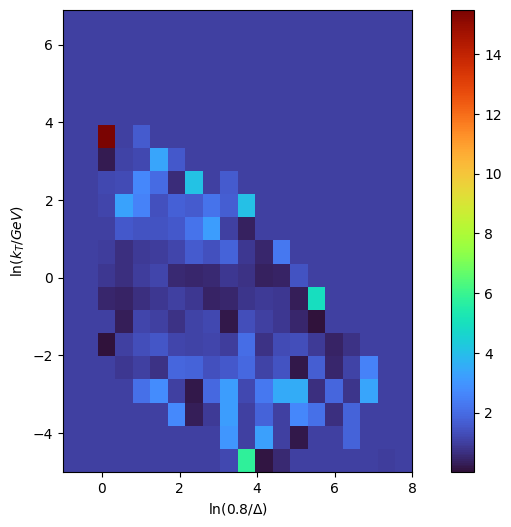

In [32]:
plt.figure(figsize=(10, 6))
plt.imshow(ratio_nom[5].T[::-1], extent=[-1, 8, -5, 6.9], cmap="turbo")
plt.xlabel(r"ln$(0.8/\Delta)$")
plt.ylabel(r"ln$(k_T/GeV)$")
_ = plt.colorbar()


In [27]:
n_sf_toys = 100
np.random.seed(42)
rand_noise = np.random.normal(size=[n_sf_toys, *ratio_nom.shape])

# produces array of shape ``[n_sf_toys, subjet_pt bins, ln(0.8/Delta) bins, ln(kT/GeV) bins]``
ratio_nom_smeared = ratio_nom + (ratio_nom_errs * rand_noise)
ratio_smeared_lookups = [
    dense_lookup(ratio_nom_smeared[i], ratio_nom_edges) for i in range(n_sf_toys)
]


In [ ]:
kappa = (ratio_nom + ratio_nom_errs) / ratio_nom
ratio_nom * np.power(kappa, rand_noise)


In [27]:
# save offsets to recover awkward structure later
ld_offsets = lds.kt.layout.offsets
flat_logD = np.log(0.8 / ak.flatten(lds).Delta).to_numpy()
flat_logkt = np.log(ak.flatten(lds).kt).to_numpy()
# repeat subjet pt for each lund declustering
flat_subjet_pt = np.repeat(ak.flatten(kt_subjets_pt), ak.count(lds.kt, axis=1)).to_numpy()


In [38]:
sf_vals = []
# could be parallelised but not sure if memory / time trade-off is worth it
for i, ratio_nom_lookup in enumerate(ratio_smeared_lookups):
    ratio_nom_vals = ratio_nom_lookup(flat_subjet_pt, flat_logD, flat_logkt)
    reshaped_ratio_nom_vals = ak.Array(
        ak.layout.ListOffsetArray64(ld_offsets, ak.layout.NumpyArray(ratio_nom_vals))
    )
    sf_vals.append(
        np.prod(ak.prod(reshaped_ratio_nom_vals, axis=1).to_numpy().reshape(-1, num_prongs), axis=1)
    )

sf_vals = np.array(sf_vals)


In [39]:
sf_vals


array([[ 0.49796394,  0.        ,  0.22907251, ...,  0.2056961 ,
         0.04563967,  0.01188678],
       [ 0.72128457,  0.        ,  0.22829882, ...,  0.11487285,
         0.47032795, -0.10045313],
       [ 0.1410559 ,  0.        ,  0.36949193, ...,  0.37087644,
         1.4134961 , -0.09676024],
       ...,
       [ 0.91281633,  0.        ,  0.84456249, ...,  0.29981497,
         0.93717329,  0.00564959],
       [ 0.60206094,  0.        ,  0.28694875, ...,  0.62489011,
         0.33897339, -0.35602571],
       [ 0.17253641,  0.        ,  0.195653  , ...,  0.95647311,
         0.22541971, -0.11804788]])

#### Old way of uncertainty calculation (not taking into account intra-jet correlations)

In [118]:
# save offsets to recover awkward structure later
ld_offsets = lds.kt.layout.offsets
flat_logD = np.log(0.8 / ak.flatten(lds).Delta).to_numpy()
flat_logkt = np.log(ak.flatten(lds).kt).to_numpy()
# repeat subjet pt for each lund declustering
flat_subjet_pt = np.repeat(ak.flatten(kt_subjets_pt), ak.count(lds.kt, axis=1)).to_numpy()


In [176]:
ratio_nom_vals = ratio_nom_lookup(flat_subjet_pt, flat_logD, flat_logkt)
ratio_nom_rel_errs = np.nan_to_num(
    (ratio_nom_errs_lookup(flat_subjet_pt, flat_logD, flat_logkt) / ratio_nom_vals) ** 2
)

reshaped_ratio_nom_vals = ak.Array(
    ak.layout.ListOffsetArray64(ld_offsets, ak.layout.NumpyArray(ratio_nom_vals))
)
reshaped_ratio_nom_rel_errs = ak.Array(
    ak.layout.ListOffsetArray64(ld_offsets, ak.layout.NumpyArray(ratio_nom_rel_errs))
)

sf_nom_vals = np.prod(
    ak.prod(reshaped_ratio_nom_vals, axis=1).to_numpy().reshape(-1, num_prongs), axis=1
)
sf_nom_errs = (
    np.sqrt(
        np.sum(
            ak.sum(reshaped_ratio_nom_rel_errs, axis=1).to_numpy().reshape(-1, num_prongs), axis=1
        )
    )
    * sf_nom_vals
)


In [177]:
sf_nom_vals


array([0.2987439 , 0.        , 0.40326303, ..., 0.40680158, 1.0423063 ,
       0.00966673], dtype=float32)

In [178]:
sf_nom_errs


array([0.18848526, 0.        , 0.2404116 , ..., 0.42433724, 1.07653282,
       0.0865682 ])

In [ ]:
def get_ld_indices(vals, edges):
    indices = []

    for val, edge in zip(vals, edges):
        indices.append(
            np.clip(
                np.searchsorted(edge, val, side="right") - 1,
                0,
                len(edge) - 2,
            )
        )

    return indices


In [135]:
# get lund plane bins
inds = get_ld_indices((flat_subjet_pt, flat_logD, flat_logkt), ratio_nom_edges)
# convert 3D indices to single scalar
scalar_inds = np.ravel_multi_index(inds, ratio_nom.shape)
reshaped_inds = ak.Array(ak.layout.ListOffsetArray64(ld_offsets, ak.layout.NumpyArray(scalar_inds)))
# reshaped_inds = pad_val(reshaped_inds, 40, -1, axis=1, clip=False)


In [179]:
dups = 0
for row in reshaped_inds:
    _, counts = np.unique(row, return_counts=True)
    dups += np.sum(counts - 1)

print(f"Fraction of duplicate splittings: {dups / len(flat_logD):.2f}")


Fraction of duplicate splittings: 0.05
